In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
import tensorflow.keras
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [ ]:
cancer_dataset=load_breast_cancer()
assert isinstance(cancer_dataset,dict)
print(cancer_dataset.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
X=pd.DataFrame(cancer_dataset['data'],columns=cancer_dataset.feature_names)
Y=cancer_dataset['target']

In [ ]:
cancer=pd.DataFrame(cancer_dataset['data'],columns=cancer_dataset['feature_names'])
cancer['MEDV']=cancer_dataset['target']

In [ ]:
print('{}samples,{}columns'.format(*cancer.shape))

569samples,31columns


In [ ]:
X=cancer.drop('MEDV',axis=1).values
y=cancer['MEDV'].values

X=X.astype(np.float32)
y=y.astype(np.float32)

In [ ]:
tr_x,ts_x,tr_y,ts_y=train_test_split(X,y,train_size=7,stratify=y)
print('train:',tr_x.shape,tr_y.shape)
print('test:',ts_x.shape,ts_y.shape)

train: (7, 30) (7,)
test: (562, 30) (562,)


In [ ]:
tr_x=torch.from_numpy(tr_x)
ts_x=torch.from_numpy(ts_x)
tr_y=torch.from_numpy(tr_y).to(torch.long)
ts_y=torch.from_numpy(ts_y).to(torch.long)

In [ ]:
class LinearRegressionModel(torch.nn.Module):

    def __init__(self,in_features):
        super().__init__()
        self.linear=nn.Linear(in_features,1,bias=True)
        self.output=nn.Sigmoid()

    def forward(self, x):
        logits=self.linear(x)
        probs=self.output(logits)
        
        return probs

In [ ]:
class LinearRegressionModel2(torch.nn.Module):

    def __init__(self,in_features):
        super().__init__()
        self.linear=nn.Linear(in_features,2,bias=True)
        self.output=nn.Softmax()

    def forward(self, x):
        out1=self.linear(x)
        probs=self.output(out1)

        return probs

In [ ]:
class LinearRegressionModel3(torch.nn.Module):

    def __init__(self,in_features):
        super().__init__()
        self.linear=nn.Linear(in_features,5,bias=True)
        self.hidden=nn.Linear(5,2,bias=True) # 2->3갈때는 히든레이어 하나 추가
        self.output=nn.Softmax()

    def forward(self, x):
        out1=self.linear(x)
        out2=self.hidden(out1)
        probs=self.output(out2)

        return probs

In [ ]:
class LinearRegressionModel4(torch.nn.Module):

    def __init__(self,in_features):
        super().__init__()
        self.linear=nn.Linear(in_features,5,bias=True)
        self.act_fun1=nn.Sigmoid()
        self.hidden=nn.Linear(5,2,bias=True) # 2->3갈때는 히든레이어 하나 추가
        self.output=nn.Softmax()
        '''
        Regression의 경우(Classification아닌 경우)
        self.hidden=nn.Linear(5,1,bias=True) # 2->3갈때는 히든레이어 하나 추가
        softmax 안써줌 하나로 합칠 필요 없
        '''
    def forward(self, x):
        out1=self.linear(x)
        sig1=self.act_fun1(out1)
        out2=self.hidden(sig1)
        probs=self.output(out2)

        return probs

In [ ]:
model=LinearRegressionModel(in_features=X.shape[1])
model2=LinearRegressionModel2(in_features=X.shape[1])
model3=LinearRegressionModel3(in_features=X.shape[1])
model4=LinearRegressionModel4(in_features=X.shape[1])

In [ ]:
criterion2=nn.CrossEntropyLoss()
criterion3=nn.CrossEntropyLoss()
criterion4=nn.CrossEntropyLoss()
binary_criterion=nn.BCELoss()

In [ ]:
optimizer1=torch.optim.SGD(params=model.parameters(),lr=0.01)
optimizer2=torch.optim.SGD(params=model2.parameters(),lr=0.01)
optimizer3=torch.optim.SGD(params=model3.parameters(),lr=0.01)
optimizer4=torch.optim.SGD(params=model4.parameters(),lr=0.01)

lr을 줄인다는건 조금씩 조금씩 학습을 한다는 거니까 
학습률을 줄여준다
lr을 조절해본다

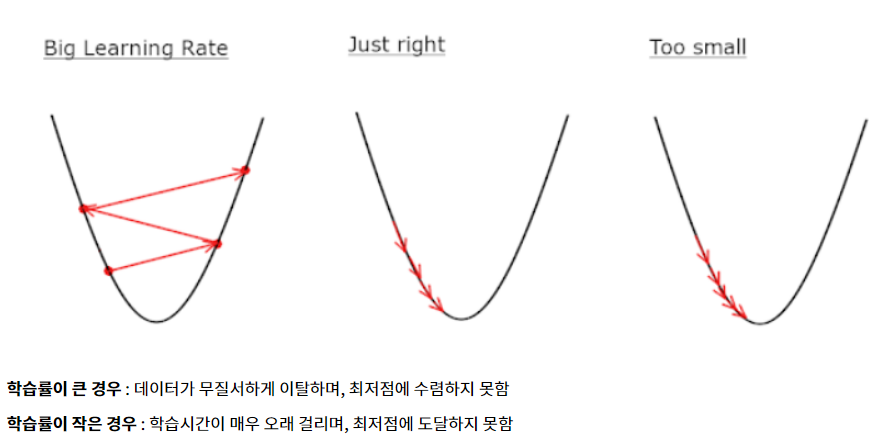

In [ ]:
loss_set=dict(train=dict(model=[],model2=[],model3=[],model4=[]),test=dict(model=[],model2=[],model3=[],model4=[]))

In [ ]:
epoches=1000
for i in range(epoches):
  model.train()
  model2.train()
  model3.train()
  model4.train()

  optimizer1.zero_grad()
  optimizer2.zero_grad()
  optimizer3.zero_grad()
  optimizer4.zero_grad()

  y_train_pred1=model(tr_x)
  y_train_pred2=model2(tr_x)
  y_train_pred3=model3(tr_x)
  y_train_pred4=model4(tr_x)


  loss1=binary_criterion(y_train_pred1,tr_y.unsqueeze(-1).to(torch.float32))
  loss2=criterion2(y_train_pred2,tr_y)
  loss3=criterion3(y_train_pred3,tr_y)
  loss4=criterion4(y_train_pred4,tr_y)

  loss1.backward()
  loss2.backward()
  loss3.backward()
  loss4.backward()

  optimizer1.step()
  optimizer2.step()
  optimizer3.step()
  optimizer4.step()

  train_loss1=loss1.item()
  train_loss2=loss2.item()
  train_loss3=loss3.item()
  train_loss4=loss4.item()

  loss_set['train']['model'].append(train_loss1)
  loss_set['train']['model2'].append(train_loss2)
  loss_set['train']['model3'].append(train_loss3)
  loss_set['train']['model4'].append(train_loss4)

  num_correct1=(tr_y.unsqueeze(-1).to(torch.float32)==y_train_pred1.round()).float().sum().item()
  num_correct2=(tr_y==y_train_pred2.argmax(dim=1)).float().sum().item() 
  num_correct3=(tr_y==y_train_pred3.argmax(dim=1)).float().sum().item() 
  num_correct4=(tr_y==y_train_pred4.argmax(dim=1)).float().sum().item() 

  train_acc1=num_correct1/tr_x.shape[0]
  train_acc2=num_correct1/tr_x.shape[0]
  train_acc3=num_correct1/tr_x.shape[0]
  train_acc4=num_correct1/tr_x.shape[0]

  if(i+1)%10==0:
    model.eval()
    model2.eval()
    model3.eval()
    model4.eval()

  with torch.no_grad():
    y_test_pred1=model(ts_x)
    y_test_pred2=model2(ts_x)
    y_test_pred3=model3(ts_x)
    y_test_pred4=model4(ts_x)

    test_loss1=binary_criterion(y_test_pred1,ts_y.unsqueeze(-1).to(torch.float32)).item()
    test_loss2=criterion2(y_test_pred2,ts_y).item()
    test_loss3=criterion3(y_test_pred3,ts_y).item()
    test_loss4=criterion4(y_test_pred4,ts_y).item()
    
    num_correct1=(ts_y.unsqueeze(-1).to(torch.float32)==y_test_pred1.round()).float().sum().item()
    num_correct2=(ts_y==y_test_pred2.argmax(dim=1)).float().sum().item() 
    num_correct3=(ts_y==y_test_pred3.argmax(dim=1)).float().sum().item() 
    num_correct4=(ts_y==y_test_pred4.argmax(dim=1)).float().sum().item() 

    test_acc1=num_correct1/ts_x.shape[0]
    test_acc2=num_correct1/ts_x.shape[0]
    test_acc3=num_correct1/ts_x.shape[0]
    test_acc4=num_correct1/ts_x.shape[0]

  print(f'lteration:{i+1:>05d} | Training Loss:{train_loss1:.3f} | Test loss:{test_loss1:.3f} | Train Acc : {train_acc1:.3f} | Test Acc : {test_acc1:.3f} ')
  print(f'lteration:{i+1:>05d} | Training Loss:{train_loss2:.3f} | Test loss:{test_loss2:.3f} | Train Acc : {train_acc2:.3f} | Test Acc : {test_acc2:.3f}')
  print(f'lteration:{i+1:>05d} | Training Loss:{train_loss3:.3f} | Test loss:{test_loss3:.3f} | Train Acc : {train_acc3:.3f} | Test Acc : {test_acc3:.3f}')
  print(f'lteration:{i+1:>05d} | Training Loss:{train_loss4:.3f} | Test loss:{test_loss4:.3f} | Train Acc : {train_acc4:.3f} | Test Acc : {test_acc4:.3f}')
  print('##################################################################')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


lteration:00001 | Training Loss:42.857 | Test loss:37.189 | Train Acc : 0.571 | Test Acc : 0.628 
lteration:00001 | Training Loss:0.885 | Test loss:0.941 | Train Acc : 0.571 | Test Acc : 0.628
lteration:00001 | Training Loss:0.742 | Test loss:0.685 | Train Acc : 0.571 | Test Acc : 0.628
lteration:00001 | Training Loss:0.792 | Test loss:0.829 | Train Acc : 0.571 | Test Acc : 0.628
##################################################################
lteration:00002 | Training Loss:42.857 | Test loss:37.189 | Train Acc : 0.571 | Test Acc : 0.628 
lteration:00002 | Training Loss:0.885 | Test loss:0.941 | Train Acc : 0.571 | Test Acc : 0.628
lteration:00002 | Training Loss:0.742 | Test loss:0.685 | Train Acc : 0.571 | Test Acc : 0.628
lteration:00002 | Training Loss:0.792 | Test loss:0.829 | Train Acc : 0.571 | Test Acc : 0.628
##################################################################
lteration:00003 | Training Loss:42.857 | Test loss:37.189 | Train Acc : 0.571 | Test Acc : 0.628 
lt

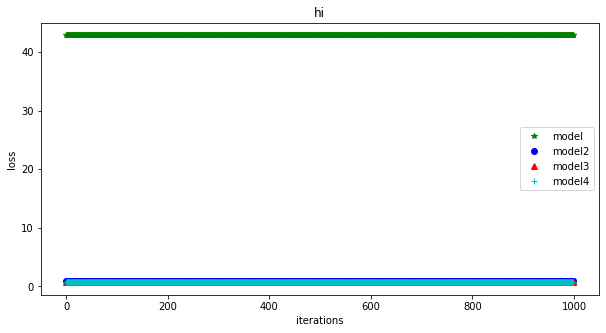

In [ ]:

plt.figure(figsize=(10,5))
plt.title('hi')

plt.plot(loss_set['train']['model'],'g*',label='model')
plt.plot(loss_set['train']['model2'],'bo',label='model2')
plt.plot(loss_set['train']['model3'],'r^',label='model3')
plt.plot(loss_set['train']['model4'],'c+',label='model4')

plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression

In [ ]:
lr=LogisticRegression()
lr.fit(tr_x.numpy(),tr_y.numpy())

LogisticRegression()

In [ ]:
sk_logistic_pred=lr.predict(ts_x.numpy())

In [ ]:
(sk_logistic_pred==ts_y.numpy()).sum()/len(ts_y)

0.8131672597864769

코드가 안 된다
1. optimizer의 문제일까?
2. lr을 바꿔본다 그래도 안 된다면 
3. 확인을 위해 sklearn에서 검증된 알고리즘을 가지고 와본다(정확도가 높게 나오네? 뭐가 문제지?)
4. scaling은 어떨까(=단위를 맞춰준다), 특히나 미분을 하는 NN에서는 scaling이 중요하다
[스케일링](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [ ]:
X=pd.DataFrame(cancer_dataset['data'],columns=cancer_dataset.feature_names)
Y=cancer_dataset['target']
X.astype(np.float)
Y.astype(np.float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
       0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
       1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       1., 1., 0., 1., 1.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler=StandardScaler()

In [ ]:
X=scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
tr_x,ts_x,tr_y,ts_y=train_test_split(X,y,train_size=7,stratify=y)

In [ ]:
tr_x=torch.from_numpy(tr_x).to(torch.float)
ts_x=torch.from_numpy(ts_x).to(torch.float)
tr_y=torch.from_numpy(tr_y).to(torch.long)
ts_y=torch.from_numpy(ts_y).to(torch.long)

In [ ]:
loss_set=dict(train=dict(model=[],model2=[],model3=[],model4=[]),test=dict(model=[],model2=[],model3=[],model4=[]))

In [ ]:
epoches=1000
for i in range(epoches):
  model.train()
  model2.train()
  model3.train()
  model4.train()

  optimizer1.zero_grad()
  optimizer2.zero_grad()
  optimizer3.zero_grad()
  optimizer4.zero_grad()

  y_train_pred1=model(tr_x)
  y_train_pred2=model2(tr_x)
  y_train_pred3=model3(tr_x)
  y_train_pred4=model4(tr_x)


  loss1=binary_criterion(y_train_pred1,tr_y.unsqueeze(-1).to(torch.float32))
  loss2=criterion2(y_train_pred2,tr_y)
  loss3=criterion3(y_train_pred3,tr_y)
  loss4=criterion4(y_train_pred4,tr_y)

  loss1.backward()
  loss2.backward()
  loss3.backward()
  loss4.backward()

  optimizer1.step()
  optimizer2.step()
  optimizer3.step()
  optimizer4.step()

  train_loss1=loss1.item()
  train_loss2=loss2.item()
  train_loss3=loss3.item()
  train_loss4=loss4.item()

  loss_set['train']['model'].append(train_loss1)
  loss_set['train']['model2'].append(train_loss2)
  loss_set['train']['model3'].append(train_loss3)
  loss_set['train']['model4'].append(train_loss4)

  num_correct1=(tr_y.unsqueeze(-1).to(torch.float32)==y_train_pred1.round()).float().sum().item()
  num_correct2=(tr_y==y_train_pred2.argmax(dim=1)).float().sum().item() 
  num_correct3=(tr_y==y_train_pred3.argmax(dim=1)).float().sum().item() 
  num_correct4=(tr_y==y_train_pred4.argmax(dim=1)).float().sum().item() 

  train_acc1=num_correct1/tr_x.shape[0]
  train_acc2=num_correct1/tr_x.shape[0]
  train_acc3=num_correct1/tr_x.shape[0]
  train_acc4=num_correct1/tr_x.shape[0]

  if(i+1)%10==0:
    model.eval()
    model2.eval()
    model3.eval()
    model4.eval()

  with torch.no_grad():
    y_test_pred1=model(ts_x)
    y_test_pred2=model2(ts_x)
    y_test_pred3=model3(ts_x)
    y_test_pred4=model4(ts_x)

    test_loss1=binary_criterion(y_test_pred1,ts_y.unsqueeze(-1).to(torch.float32)).item()
    test_loss2=criterion2(y_test_pred2,ts_y).item()
    test_loss3=criterion3(y_test_pred3,ts_y).item()
    test_loss4=criterion4(y_test_pred4,ts_y).item()
    
    num_correct1=(ts_y.unsqueeze(-1).to(torch.float32)==y_test_pred1.round()).float().sum().item()
    num_correct2=(ts_y==y_test_pred2.argmax(dim=1)).float().sum().item() 
    num_correct3=(ts_y==y_test_pred3.argmax(dim=1)).float().sum().item() 
    num_correct4=(ts_y==y_test_pred4.argmax(dim=1)).float().sum().item() 

    test_acc1=num_correct1/ts_x.shape[0]
    test_acc2=num_correct1/ts_x.shape[0]
    test_acc3=num_correct1/ts_x.shape[0]
    test_acc4=num_correct1/ts_x.shape[0]

  print(f'lteration:{i+1:>05d} | Training Loss:{train_loss1:.3f} | Test loss:{test_loss1:.3f} | Train Acc : {train_acc1:.3f} | Test Acc : {test_acc1:.3f} ')
  print(f'lteration:{i+1:>05d} | Training Loss:{train_loss2:.3f} | Test loss:{test_loss2:.3f} | Train Acc : {train_acc2:.3f} | Test Acc : {test_acc2:.3f}')
  print(f'lteration:{i+1:>05d} | Training Loss:{train_loss3:.3f} | Test loss:{test_loss3:.3f} | Train Acc : {train_acc3:.3f} | Test Acc : {test_acc3:.3f}')
  print(f'lteration:{i+1:>05d} | Training Loss:{train_loss4:.3f} | Test loss:{test_loss4:.3f} | Train Acc : {train_acc4:.3f} | Test Acc : {test_acc4:.3f}')
  print('##################################################################')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


lteration:00001 | Training Loss:1.119 | Test loss:0.858 | Train Acc : 0.000 | Test Acc : 0.215 
lteration:00001 | Training Loss:0.633 | Test loss:0.661 | Train Acc : 0.000 | Test Acc : 0.215
lteration:00001 | Training Loss:0.793 | Test loss:0.749 | Train Acc : 0.000 | Test Acc : 0.215
lteration:00001 | Training Loss:0.693 | Test loss:0.696 | Train Acc : 0.000 | Test Acc : 0.215
##################################################################
lteration:00002 | Training Loss:1.025 | Test loss:0.812 | Train Acc : 0.000 | Test Acc : 0.253 
lteration:00002 | Training Loss:0.617 | Test loss:0.652 | Train Acc : 0.000 | Test Acc : 0.253
lteration:00002 | Training Loss:0.788 | Test loss:0.746 | Train Acc : 0.000 | Test Acc : 0.253
lteration:00002 | Training Loss:0.692 | Test loss:0.695 | Train Acc : 0.000 | Test Acc : 0.253
##################################################################
lteration:00003 | Training Loss:0.939 | Test loss:0.770 | Train Acc : 0.143 | Test Acc : 0.335 
lteratio

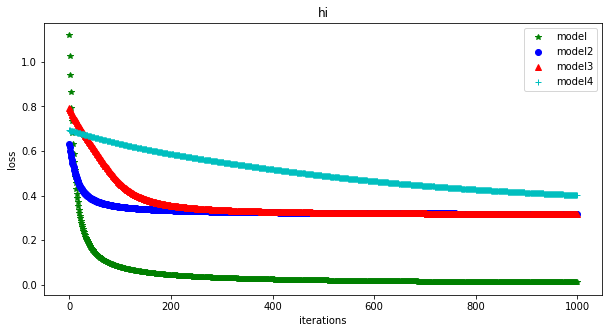

In [ ]:

plt.figure(figsize=(10,5))
plt.title('hi')

plt.plot(loss_set['train']['model'],'g*',label='model')
plt.plot(loss_set['train']['model2'],'bo',label='model2')
plt.plot(loss_set['train']['model3'],'r^',label='model3')
plt.plot(loss_set['train']['model4'],'c+',label='model4')

plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()